In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
len(words)

32033

In [20]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [21]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# using kaiming init for initialization of the weights  
# the formula is: gain / sqrt(fan_in)
# gain for tanh is 5/3: https://pytorch.org/docs/stable/nn.init.html
# and fan_mode is basically: (n_embd * block_size) ** 0.5
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size) ** 0.5
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01 // no need this bias since we have the batchnorm 'bnbias' below thats taking care of the bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # we start with small weights
b2 = torch.randn(vocab_size,                      generator=g) * 0 # since we don't want to start with a bias

bngain = torch.ones((1, n_hidden)) # we start with no bias
bnbias = torch.zeros((1, n_hidden)) # we start
# running averages for batch normalization
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, b1, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


* Initially, in 0th iteration we had loss of like 28 which is very high since misconfugiration
* in initalization we actually have no reason to have such high loss since no character is likely to be predicted than other

* we'd expect the uniform distribution 1/27 instead of 27

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation. not need to add the bias since later substraction it and no meaning.
  #we have the batchnorm 'bnbias' below thats taking care of the bias

  # since bngain is initialized to 1 and bnbias to 0, at initizaliton, each neurons firing values in this batch will be exactly unit gaussian
  # this is the batch normalization layer implementation
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias

  # for ith iteration, we are normalizing the ith batch. So, we are normalizing the ith batch with the mean and std of the ith batch
  bnmeani = hpreact.mean(0, keepdim=True) 
  bnstdi = hpreact.std(0, keepdim=True)

  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  # one of the concepts also introduced in the batchnorm paper was estimating mean and std in a running manner during the training
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer. we need logits to be more closer to 0.
  # logits being like 0, 17, 23 is not good. We need them to be like 0.1, 0.2, 0.3

  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


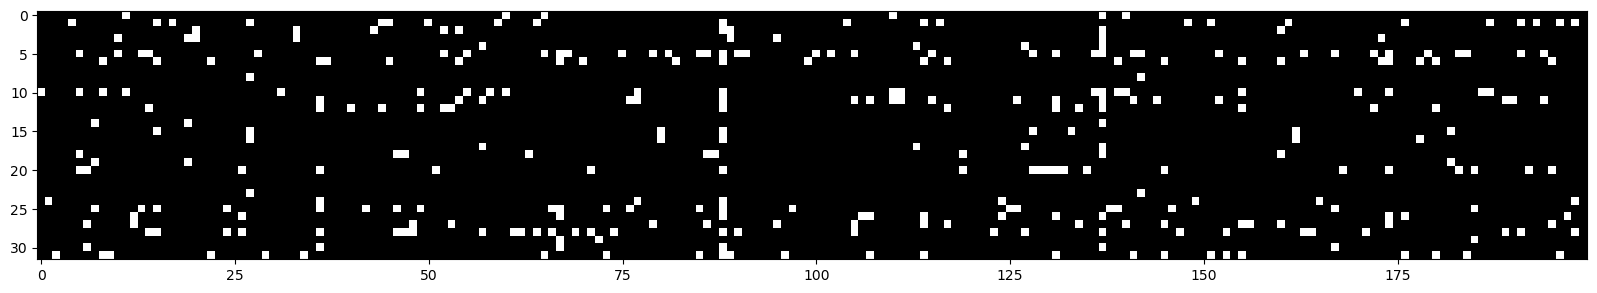

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# We can face dead neuron problem. If the saturated tanh is the case, then the neuron is dead.
# That problem isnt only for tanh, it is for all activation functions.

# problem occurs when neurons stop updating their weights because their gradients become too small (or zero), preventing them from learning. 
# This is mainly observed in activation functions like tanh and sigmoid, where saturation occurs.

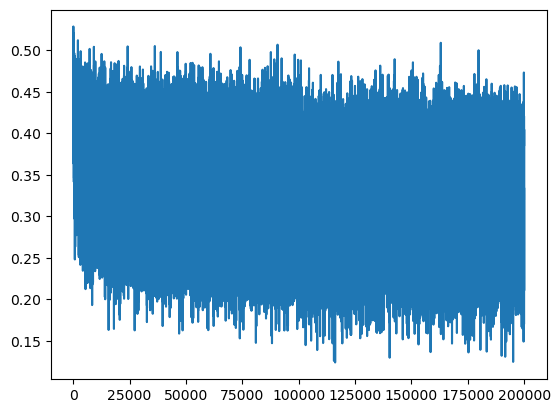

In [25]:
plt.plot(lossi)

In [26]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measuring mean and std of the hidden layer
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [27]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1 # (N, n_hidden)
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)  
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.983689308166504
val 3.011362314224243


loss log
original:
train 2.1245384216308594 val 2.168196439743042

fix softmax confidently wrong:
train 2.07 val 2.13

fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

add batch norm layer
train 2.0668270587921143 val 2.104844808578491

In [28]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (1,n_hidden)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpahzarbriq.
shlimrixtts.
lusslaysierricnenddhn.
frtivgqliyah.
farrichaiirdnsleggyu.
bmanvitte.
sants.
lustvi.
vabbuwatth.
giidryxiidh.
sulipsables.
falia.
gtas.
jasfaylahas.
bduricsydustquovozswy.
bjumillassannyks.
sadlusoffordst.
sramsryndlycpllmanraq.
shelseombriyabhda.
ffxrdustvebndvi.
